In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from omegaconf import OmegaConf
import pandas as pd

In [3]:
from dinov2.models.vision_transformer import vit_large
from dinov2.models import build_model_from_cfg
from dinov2.utils.utils import load_pretrained_weights

In [4]:
root = "/home/manon/classification/data/Single_cells/barcelona"
translate = {0: 'band_neutrophil',
 1: 'basophil',
 2: 'eosinophil',
 3: 'erythroblast',
 4: 'immature_granulocyte',
 5: 'lymphocyte',
 6: 'metamyelocyte',
 7: 'monocyte',
 8: 'myelocyte',
 9: 'neutrophil',
 10: 'platelet',
 11: 'promyelocyte',
 12: 'segmented_neutrophil'}
target_dict = {v: k for k, v in translate.items()}

## Nearest Neighbors

Nearest Neighbors algo is a good way to test the quality of embeddings : if the embedding space into which the images are projected is relevant, then their closest neighbors should be a of the same class.

### 1 NN

In this case the Barcelona dataset is split into 5 sets to perform cross-validation using a 1 nn classifier, ie the data in the test set is
predicted as of the same class as the closest one in the training dataset.

In [5]:
emb = torch.load('cache/barcelona_embs_vitl_register.pt').to('cpu').numpy()
labs = torch.load("cache/barcelona_labels.pt").numpy()
global_metrics = []

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, classification_report, confusion_matrix

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=24)
metrics = []

for train, test in kf.split(emb):
    X_train = emb[train, :]
    X_test = emb[test, :]
    y_train = labs[train]
    y_test = labs[test]
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    metrics.append([
        f1_score(y_test, preds, average='weighted'),
        recall_score(y_test, preds, average='weighted'),
        precision_score(y_test, preds, average='weighted'),
        balanced_accuracy_score(y_test, preds)
    ])

df = pd.DataFrame(metrics, columns=['f1_score', 'recall', 'precision', 'balanced_accuracy'])
df = df.round(3) * 100
global_metrics.append([f"{m} (+/- {std})" for m, std in zip(df.mean().round(1).to_list(), df.std().round(1).to_list())])
df

,f1_score,recall,precision,balanced_accuracy
0,86.5,86.5,86.5,84.7
1,85.6,85.7,85.6,84.9
2,86.7,86.8,86.8,85.2
3,87.5,87.6,87.5,85.9
4,86.6,86.7,86.6,85.3


*weighted metrics for each split of the cross validation fit of a 1nn model on the embeddings*

In [8]:
print(classification_report(preds, y_test, target_names=target_dict))

                      precision    recall  f1-score   support

     band_neutrophil       0.61      0.69      0.65       289
            basophil       0.93      0.96      0.95       233
          eosinophil       1.00      1.00      1.00       639
        erythroblast       0.97      0.99      0.98       301
immature_granulocyte       0.94      0.94      0.94        33
          lymphocyte       0.99      0.97      0.98       264
       metamyelocyte       0.56      0.62      0.59       197
            monocyte       0.95      0.89      0.92       288
           myelocyte       0.60      0.61      0.61       227
          neutrophil       1.00      1.00      1.00        15
            platelet       1.00      1.00      1.00       459
        promyelocyte       0.76      0.68      0.71       111
segmented_neutrophil       0.78      0.70      0.74       364

            accuracy                           0.87      3420
           macro avg       0.85      0.85      0.85      3420
      

*classification report for the last model*

### 20 NN

In this case the data in the test set is predicted as the majority among its closest neighbors.

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=24)
metrics = []

for train, test in kf.split(emb):
    X_train = emb[train, :]
    X_test = emb[test, :]
    y_train = labs[train]
    y_test = labs[test]
    clf = KNeighborsClassifier(n_neighbors=20)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    metrics.append([
        f1_score(y_test, preds, average='weighted'),
        recall_score(y_test, preds, average='weighted'),
        precision_score(y_test, preds, average='weighted'),
        balanced_accuracy_score(y_test, preds)
    ])

df = pd.DataFrame(metrics, columns=['f1_score', 'recall', 'precision', 'balanced_accuracy'])
df = df.round(3) * 100
global_metrics.append([f"{m} (+/- {std})" for m, std in zip(df.mean().round(1).to_list(), df.std().round(1).to_list())])
df

,f1_score,recall,precision,balanced_accuracy
0,88.5,88.6,88.6,87.6
1,88.5,88.7,88.6,87.8
2,89.9,90.1,90.0,89.0
3,88.8,88.9,89.0,87.3
4,89.6,89.8,89.7,89.0


*weighted metrics for each split of the cross validation fit of a 20nn model on the embeddings*

In [10]:
print(classification_report(preds, y_test, target_names=target_dict))

                      precision    recall  f1-score   support

     band_neutrophil       0.66      0.75      0.70       286
            basophil       0.96      0.95      0.95       243
          eosinophil       1.00      1.00      1.00       641
        erythroblast       0.96      1.00      0.98       294
immature_granulocyte       1.00      0.92      0.96        36
          lymphocyte       1.00      0.95      0.98       270
       metamyelocyte       0.64      0.74      0.68       188
            monocyte       0.96      0.93      0.94       281
           myelocyte       0.68      0.74      0.71       211
          neutrophil       1.00      1.00      1.00        15
            platelet       1.00      1.00      1.00       460
        promyelocyte       0.82      0.74      0.78       109
segmented_neutrophil       0.88      0.75      0.81       386

            accuracy                           0.90      3420
           macro avg       0.89      0.88      0.88      3420
      

*classification report for the last model*

## Linear probing

In [11]:
from sklearn.linear_model import LogisticRegression
import warnings

In [12]:
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5, shuffle=True, random_state=24)
metrics = []

for train, test in kf.split(emb):
    X_train = emb[train, :]
    X_test = emb[test, :]
    y_train = labs[train]
    y_test = labs[test]
    clf = LogisticRegression(multi_class='ovr')
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    metrics.append([
        f1_score(y_test, preds, average='weighted'),
        recall_score(y_test, preds, average='weighted'),
        precision_score(y_test, preds, average='weighted'),
        balanced_accuracy_score(y_test, preds)
    ])

df = pd.DataFrame(metrics, columns=['f1_score', 'recall', 'precision', 'balanced_accuracy'])
df = df.round(3) * 100
global_metrics.append([f"{m} (+/- {std})" for m, std in zip(df.mean().round(1).to_list(), df.std().round(1).to_list())])
df

,f1_score,recall,precision,balanced_accuracy
0,91.5,91.6,91.6,90.2
1,91.9,91.9,91.8,90.7
2,91.8,91.8,91.8,90.5
3,91.4,91.3,91.5,90.0
4,91.5,91.5,91.5,90.8


*cross validation weighted metrics for a logistic regression performed on the embeddings*

In [13]:
print(classification_report(preds, y_test, target_names=target_dict))

                      precision    recall  f1-score   support

     band_neutrophil       0.75      0.77      0.76       316
            basophil       0.97      0.98      0.97       236
          eosinophil       1.00      1.00      1.00       641
        erythroblast       0.99      0.98      0.99       309
immature_granulocyte       1.00      1.00      1.00        33
          lymphocyte       0.99      0.98      0.99       259
       metamyelocyte       0.69      0.73      0.71       205
            monocyte       0.98      0.97      0.98       271
           myelocyte       0.76      0.76      0.76       229
          neutrophil       1.00      0.94      0.97        16
            platelet       1.00      1.00      1.00       456
        promyelocyte       0.83      0.76      0.79       108
segmented_neutrophil       0.85      0.83      0.84       341

            accuracy                           0.91      3420
           macro avg       0.91      0.90      0.90      3420
      

*classification report for the last model*

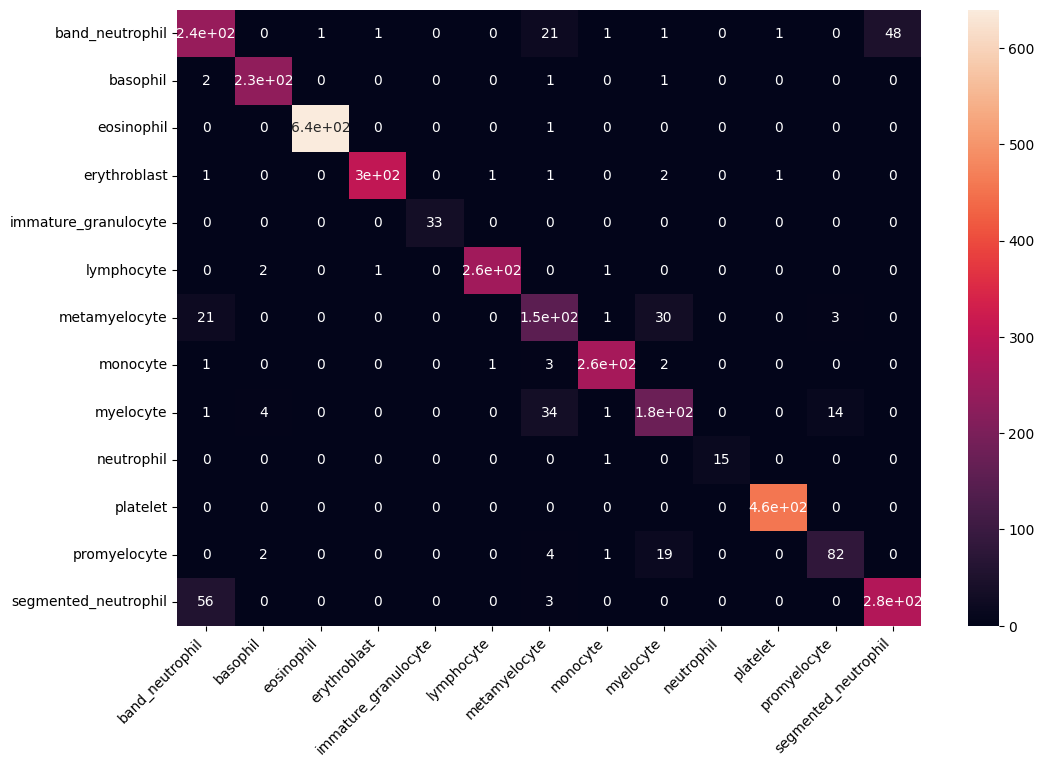

In [14]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
ax = sns.heatmap(confusion_matrix(preds, y_test), annot=True, xticklabels=target_dict, yticklabels=target_dict)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

## Global metrics

In [16]:
metrics = pd.DataFrame(
    global_metrics,
    index=["1-NN", "20-NN", "Linear Probing"],
    columns=['f1_score', 'recall', 'precision', 'balanced_accuracy'])

In [19]:
print(metrics.to_markdown())

|                | f1_score       | recall         | precision      | balanced_accuracy   |
|:---------------|:---------------|:---------------|:---------------|:--------------------|
| 1-NN           | 86.6 (+/- 0.7) | 86.7 (+/- 0.7) | 86.6 (+/- 0.7) | 85.2 (+/- 0.5)      |
| 20-NN          | 89.1 (+/- 0.7) | 89.2 (+/- 0.7) | 89.2 (+/- 0.6) | 88.1 (+/- 0.8)      |
| Linear Probing | 91.6 (+/- 0.2) | 91.6 (+/- 0.2) | 91.6 (+/- 0.2) | 90.4 (+/- 0.3)      |
